# Проект 4. Компьютер говорит «Нет»

Написать скоринговую модель предсказания дефолта клиентов банка.

Используется кредитный скоринг, который позволяет спрогнозировать вероятность невозврата кредита. Клиентов, обратившихся за кредитом, сортируют по этой предсказанной вероятности (по убыванию), и получается скоркарта — рейтинг клиентов от плохих к хорошим.

Используя данные о клиенте, работник банка может решить, выдавать ли клиенту кредит, и если да, то под какой процент.

При этом используемый в кредитном скоринге алгоритм позволяет предсказывать значения непрерывной зависимой переменной на интервале от 0 до 1. Банки самостоятельно определяют для себя значения, при которых они принимают решение об отказе в кредите.

#  1. Импорт и объединение данных

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from pandas import Series
import pandas as pd
import numpy as np

import os
import re 
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# фиксируйте RANDOM_SEED и версию пакетов, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [ ]:
#train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
#test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
#id_test = test.client_id

In [2]:
train = pd.read_csv("traink.csv", encoding = 'ISO-8859-1', low_memory = False)
test = pd.read_csv("testk.csv", encoding = 'ISO-8859-1', low_memory = False)

In [3]:
train.shape, test.shape

((73799, 19), (36349, 18))

В итоге у нас стало больше признаков, чем было на skillfactory (как и было обещано)
19 в тренировочной и 18 в тестовой

Объединим тестовый и тренировочный сеты длядальнейшей обработки

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
15792,76212,24MAR2014,SCH,F,26,N,N,0,0,-1.784471,6,40,2,3,18000,4,1,N,0
53368,105003,23APR2014,SCH,M,36,Y,N,0,1,-2.884192,2,80,2,3,132000,1,4,N,0
53029,81948,30MAR2014,SCH,F,55,Y,N,0,0,-2.816147,0,60,3,3,23000,1,4,N,0
64555,24364,31JAN2014,SCH,M,44,N,N,0,0,-1.546502,0,60,1,1,40000,2,3,N,0
14912,50473,27FEB2014,GRD,M,36,Y,N,0,0,-2.038094,0,50,1,2,20000,1,3,N,0


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

- В тренировочной выборке 73799 клиентов.
- В тестовой выборке - 36349 клиентов.
- Всего 110148 клиентов.
- В исходных данных 19 признаков:
- 1 временной ('app_date'),
- 6 бинарных ('sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default'),
- 6 категориальных ('education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time')
- 6 числовых ('client_id', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income').
- Пропуски встречаются только в признаке 'education' - 478 (в train - 307 пропусков, в test - 171 пропуск).
- client_id - числовой идентификационный признак, можно удалить.
- default - целевая переменная, есть только в данных train.

## Описание признаков:

- **app_date** - дата запроса (временная переменная)
- **education** - уровень образования (категориальная переменная)
- **sex** - пол заёмщика
- **age** - возраст заёмщика 
- **car** - наличие машины (двоичная переменная)
- **car_type**  - наличие автомобиля-иномарки (бинарная переменная)
- **decline_app_cnt** - количество отклоненных запросов (непрерывная переменная)
- **good_work** - признак хорошо оплачиваемой работы (бинарная переменная)
- **score_bki** - внутренний рейтинг БКИ (агентство кредитной информации)(непрерывная переменная, все значения которой отрицательны)
- **bki_request_cnt** - количество запросов в БКИ (агентство кредитной информации)(непрерывная переменная)
- **region_rating** - рейтинг региона (категориальная переменная)
- **home_address** - классификатор домашнего адреса (категориальная переменная)
- **work_address** - классификатор рабочих адресов (категориальная переменная)
- **income** - уровень дохода клиента (непрерывная переменная)
- **sna** - уровень связи с другими клиентами (категориальная переменная)
- **first_time** - сколько времени клиент находится в базе данных (категориальная переменная)
- **foreign_passport** - наличие  загранпаспорта (бинарная переменная)
- **default** - наличие дефолта в прошлом (бинарная целевая переменная)

Будем работать с данными для обучения, делать EDA, заполнять пропуски, генерировать признаки и т.д.

Задача - применять те же преобразования для тестовых данных, но используя статистики, полученные с данных для обучения (трейн)

Обозначим обучающиеся данные и тестовые:

In [7]:
df = train
df_test = test
id_test = test['client_id']

# 2. Разведывательный анализ данных (EDA)

Посмотрим на данные:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [9]:
df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
66281,55193,04MAR2014,GRD,F,27,Y,N,0,0,-2.470946,1,60,2,3,35000,1,3,N,0
4784,72713,20MAR2014,SCH,F,39,N,N,1,0,-1.879710,0,60,1,2,18000,1,1,N,0
10986,7916,15JAN2014,SCH,F,63,N,N,0,0,-2.203250,2,70,1,2,22000,1,3,N,0
54688,85524,02APR2014,GRD,M,35,Y,Y,0,0,-2.250073,1,70,2,3,60000,1,2,N,0
27738,50760,27FEB2014,SCH,F,30,N,N,0,0,-1.291654,0,50,3,3,30000,2,1,N,0


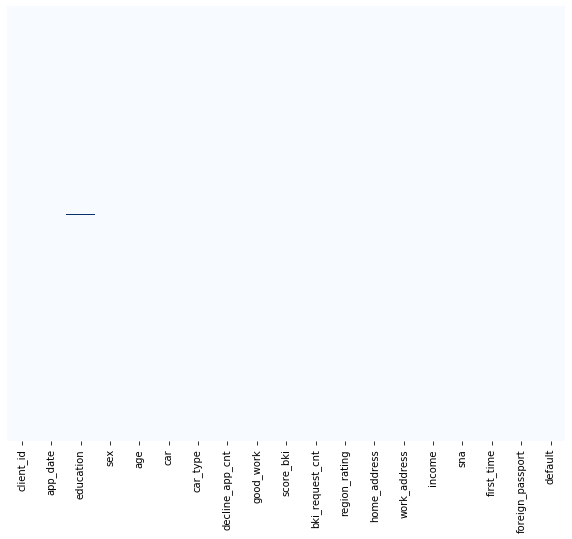

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [11]:
# пропущенные значения
df.isnull().sum(axis = 0)

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.


- заполним пропуски в столбце "education"
- сгруппируем все признаки по типу
- найдем выбросы в числовых признаках
- рассмотрим бинарные признаки
- рассмотрим категориальные признаки

### 2.1. education (уровень образования клиентa)
Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

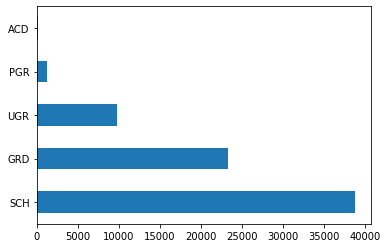

In [12]:
df['education'].value_counts().plot.barh()

- SCH - school
- UGR - undergraduate (Bachelor)
- GRD - graduate (Master or PhD)
- PGR - postgraduate (Master or PhD)
- ACD - Academic Career Development (Professor)

In [13]:
# Предположим, что зная о хорошей работе и доходах, мы сможем сделать вывод о его образовании
display(df[['good_work', 'education', 'income']].sample(10))

,good_work,education,income
3017,0,SCH,15000
21796,1,GRD,40000
34927,1,UGR,40000
43779,0,GRD,40000
18697,1,PGR,30000
39979,0,SCH,180000
43965,1,GRD,50000
67314,0,GRD,40000
56399,0,SCH,50000
72379,0,SCH,25000


In [14]:
# Посмотрим средний доход, в зависимости от образования и хорошей работы
df.groupby(['education', 'good_work']).income.mean()

education  good_work
ACD        0            90068.669903
           1            74928.065934
GRD        0            55407.223822
           1            52409.361298
PGR        0            80479.809578
           1            70782.373684
SCH        0            32193.880132
           1            30030.931856
UGR        0            39758.623666
           1            37590.786273
Name: income, dtype: float64

In [15]:
# по данным видно что при наличии образования доход выше, мы заменим GRD все значения выше 50000 иначе поставим UGR        
df['education'] = df.apply(lambda x: ('GRD' if x.income > 50000 else 'UGR')\
                             if pd.isna(x.education) else x.education , axis=1)

In [16]:
# Преобразуем этот признак в численный формат заполним NAN
df.education.fillna(value='SCH', inplace=True)

In [17]:
le = LabelEncoder()
le.fit(df["education"])
df["education"] = le.transform(df["education"])

In [18]:
df["education"]

0        3
1        3
2        3
3        3
4        1
        ..
73794    1
73795    3
73796    3
73797    3
73798    1
Name: education, Length: 73799, dtype: int32

In [19]:
print(dict(enumerate(le.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


сделаем то же самое для теста

не используем обученный на трейне энкодер для теста.
почему мы так делаем: если вдруг на тесте встретится значение, которого не было в трейне - мы получим ошибку. Чтобы максимально не вносить инфомрацию их теста в обучающее множество (и предотвращать data leakage), но иногда, например на kaggle так делают специально, чтобы как-раз таки внести немного ифнормации из теста в обучающую выборку - но для практических решений такой подход может привести к слишком оптимистичным оценкам качества

In [20]:
df_test.education.fillna(value='SCH', inplace=True)

In [21]:
le = LabelEncoder()
le.fit(df_test["education"])
df_test["education"] = le.transform(df_test["education"])

In [22]:
df_test["education"]

0        1
1        3
2        4
3        3
4        1
        ..
36344    3
36345    1
36346    1
36347    4
36348    3
Name: education, Length: 36349, dtype: int32

### 2.2. app_date (Временной признак - дата подачи заявки)

по виду мы понимаем, что это дата, но в формате object. Поменяем формат на дата

In [23]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
print(df.app_date.sample(5))

62481   2014-04-18
18599   2014-02-12
55267   2014-02-04
37      2014-04-03
47090   2014-03-26
Name: app_date, dtype: datetime64[ns]


In [24]:
df.app_date.max()

Timestamp('2014-04-30 00:00:00')

In [25]:
df.app_date.min()

Timestamp('2014-01-01 00:00:00')

Судя по цифрам, данные у нас за период с 1 января по 30 апреля 2014 года
Создадим дополнительные признаки: число дней от начала периода (1 января), месяц подачи заявки, день недели подачи заявки

In [26]:
min_day = df.app_date.min() 
df['days'] = (df.app_date - min_day).dt.days.astype('int')

In [27]:
# месяц подачи заявки
df['month'] = df.app_date.dt.month

In [28]:
# день недели подачи заявки
df['weekday'] = df.app_date.dt.weekday

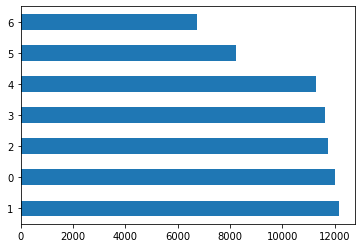

In [29]:
df['weekday'].value_counts().plot.barh()

Видно, что в будние дни заявок больше, чем в выходные

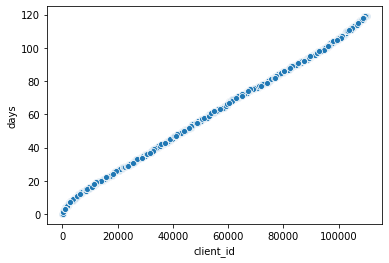

In [30]:
sns.scatterplot(x='client_id',y='days',data=df)

Идентификационый номер в 'client_id' прямо пропорционален дню подачи заявки, т.е. в банке велась последовательная нумерация заявок

сделаем то же самое для теста:

In [31]:
df_test.app_date = pd.to_datetime(df_test.app_date, format='%d%b%Y')
print(df_test.app_date.sample(5))

1625    2014-01-09
3457    2014-04-11
25634   2014-03-06
24031   2014-03-18
20861   2014-02-07
Name: app_date, dtype: datetime64[ns]


In [32]:
min_day = df_test.app_date.min() 
df_test['days'] = (df_test.app_date - min_day).dt.days.astype('int')

In [33]:
# месяц подачи заявки
df_test['month'] = df_test.app_date.dt.month

In [34]:
# день недели подачи заявки
df_test['weekday'] = df_test.app_date.dt.weekday

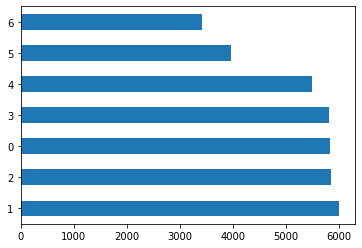

In [35]:
df_test['weekday'].value_counts().plot.barh()

### 2.3. score_bki (внутренний рейтинг БКИ (агентство кредитной информации))

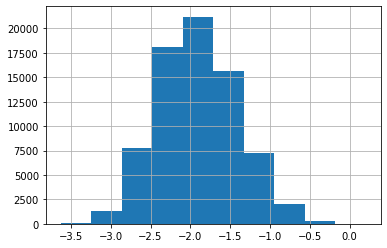

In [36]:
df.score_bki.hist();

In [37]:
df.score_bki.describe()

count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64

In [38]:
df.score_bki.sample(5)

26562   -1.766318
53356   -2.384414
37632   -2.124900
54868   -1.869878
66362   -1.617112
Name: score_bki, dtype: float64

In [ ]:
# df['score_bki'] = df['score_bki'].fillna('unknown') 

In [39]:
# Найдем выбросы, напишем функцию

def outliers(data):
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1  #находим межквартильное расстояние
    lower_bound = quartile_1 - (iqr * 1.5)  #нижняя граница коробки
    upper_bound = quartile_3 + (iqr * 1.5)  #верхняя граница коробки
    return data[((data > upper_bound) | (data < lower_bound))]


In [40]:
len(outliers(df.score_bki))/len(df.score_bki)

0.0047561620076152795

Выбросов 0,4%. Удалять не будем

In [41]:
len(outliers(df_test.score_bki))/len(df_test.score_bki)

0.00459434922556329

### 2.4.region_rating (рейтинг региона)

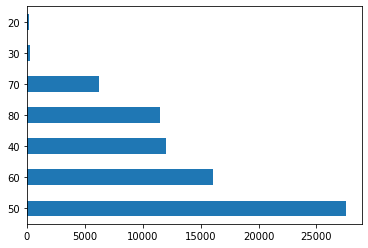

In [42]:
df['region_rating'].value_counts().plot.barh()

In [43]:
df['region_rating'].unique()

array([50, 80, 60, 40, 70, 20, 30], dtype=int64)

Видим что у нас присутствуют 7 видов регионов.

In [44]:
df_test['region_rating'].unique()

array([50, 40, 80, 60, 70, 20, 30], dtype=int64)

Видим в тестовой тоже 7 регионов 

### 2.5.sna (уровень связи с другими клиентами)

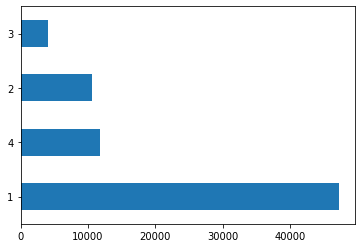

In [45]:
df['sna'].value_counts().plot.barh()

Видим 4 типа связи заяемщиков с клиентами банка

То же самое мы видим и в тестовом дата сете

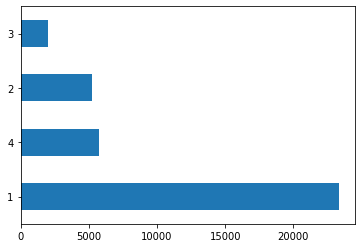

In [46]:
df_test['sna'].value_counts().plot.barh()

### 2.6.first_time (сколько времени клиент находится в базе данных (категориальная переменная))

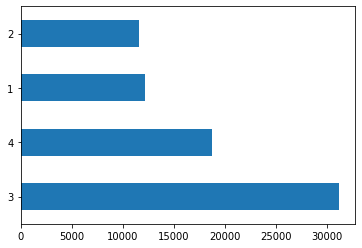

In [47]:
# давность наличия информации о заемщике

df['first_time'].value_counts().plot.barh()

Видим 4 типа давности

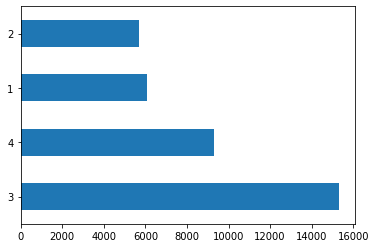

In [48]:
df_test['first_time'].value_counts().plot.barh()

### 2.7. Группировка данных по группам
Признаки сгруппируем по типу их обработки (категориальные, бинарные и числовые)

In [49]:
# определим, какие признаки являются числовыми, какие - категориальные, и какие - бинарные
df.nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
default                 2
days                  120
month                   4
weekday                 7
dtype: int64

признаки с большим количеством уникальных значений отнесем к числовым, за исключением app_date,

так как он содержит дату в виде строки, после его преобразования у нас появились новые признаки

Также не будем использовать признак client_id, так как все его значения уникальны

In [50]:
num_cols = ['days', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt',
            'region_rating', 'income']  # client_id исключили из списка

# к бинарным отнесем остальные признаки, количество уникальных значений которых равно 2
bin_cols = ['sex', 'car', 'car_type', 'good_work',
            'foreign_passport']  # default - целевая переменная

# все остальные - категориальные
cat_cols = ['month', 'education', 'home_address',
            'work_address', 'sna', 'first_time', 'weekday']


### 2.8. Числовые признаки

num_cols = ['days', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt','region_rating', 'income']

**days**

In [51]:
len(outliers(df.days))/len(df.days)

0.0

In [52]:
len(outliers(df_test.days))/len(df_test.days)

0.0

Выбросов нет

**age**

In [53]:
len(outliers(df.age))/len(df.age)

0.0

In [54]:
len(outliers(df_test.age))/len(df_test.age)

0.0

Выбросов нет

**decline_app_cnt**

In [55]:
len(outliers(df.decline_app_cnt))/len(df.decline_app_cnt)

0.17053076599953929

In [56]:
len(outliers(df_test.decline_app_cnt))/len(df_test.decline_app_cnt)

0.16759745797683567

Выбросов 17%

**bki_request_cnt**

In [57]:
len(outliers(df.bki_request_cnt))/len(df.bki_request_cnt)

0.023780810038076396

In [58]:
len(outliers(df_test.bki_request_cnt))/len(df_test.bki_request_cnt)

0.02423725549533687

Выбросов 2,5% , практически одинаковые показатели с разницей совсем не большой везде между обучающимся и тестовым

**income**

In [59]:
len(outliers(df.income))/len(df.income)

0.06361874822152061

In [60]:
len(outliers(df_test.income))/len(df_test.income)

0.06341302374205618

Выбросов 6%

Чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда можно избежать чувствительности к сильным отклонениям в суммах у линейных моделей. Построим графики распределения логарифмированных переменных.

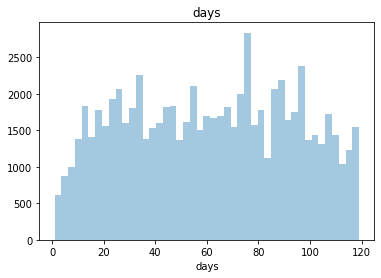

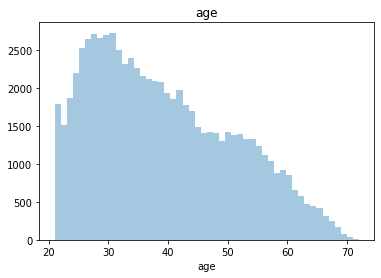

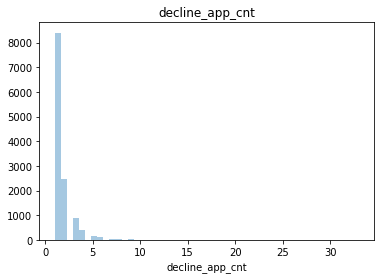

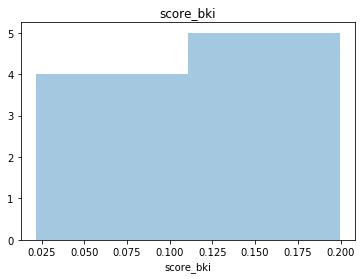

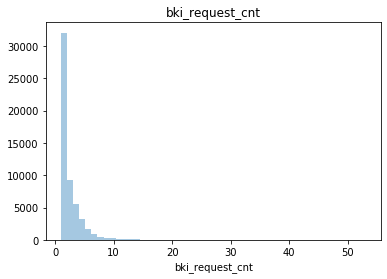

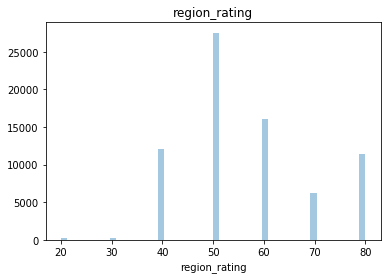

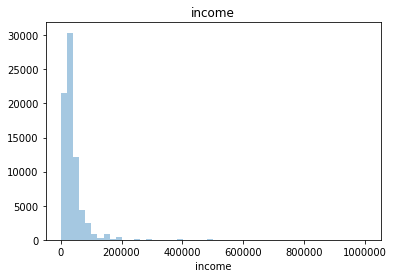

In [61]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

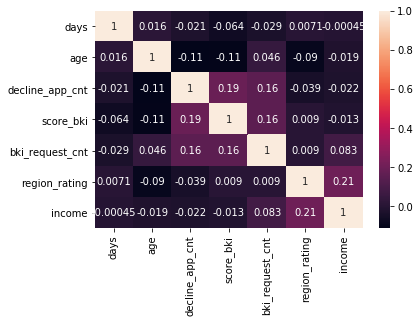

In [62]:
sns.heatmap(df[num_cols].corr(), annot = True)

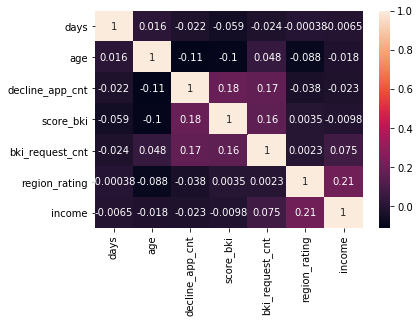

In [63]:
sns.heatmap(df_test[num_cols].corr(), annot = True)

In [64]:
df[num_cols].corr()

,days,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income
days,1.000000,0.015676,-0.021352,-0.063605,-0.029165,0.007125,-0.000454
age,0.015676,1.000000,-0.111175,-0.106275,0.046265,-0.089501,-0.018900
decline_app_cnt,-0.021352,-0.111175,1.000000,0.189987,0.155894,-0.038505,-0.021687
score_bki,-0.063605,-0.106275,0.189987,1.000000,0.156257,0.008959,-0.012639
bki_request_cnt,-0.029165,0.046265,0.155894,0.156257,1.000000,0.009025,0.082983
region_rating,0.007125,-0.089501,-0.038505,0.008959,0.009025,1.000000,0.205674
income,-0.000454,-0.018900,-0.021687,-0.012639,0.082983,0.205674,1.000000


Взаимосвязь пар числовых признаков по Пирсону слабая. Максимальный коэффициент -0.111175 и 0.205674	. Это очень хорошо для  линейной модели.

Значимость непрерывных переменных 
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

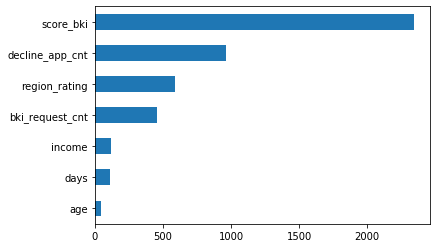

In [65]:
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

самый значимый признак из числовых  это score_bki (внутренний рейтинг БКИ (агентство кредитной информации))

### 2.9.Бинарные признаки (bin_cols)

bin_cols = ['sex', 'car', 'car_type', 'good_work','foreign_passport'] 
            
Переведем каждое значение бинарных признаков в уникальное число при помощи LabelEncoder()

In [66]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,days,month,weekday
0,25905,2014-02-01,3,1,62,1,1,0,0,-2.008753,...,1,2,18000,4,1,0,0,31,2,5
1,63161,2014-03-12,3,0,59,0,0,0,0,-1.532276,...,2,3,19000,4,1,0,0,70,3,2
2,25887,2014-02-01,3,1,25,1,0,2,0,-1.408142,...,1,2,30000,1,4,1,0,31,2,5
3,16222,2014-01-23,3,0,53,0,0,0,0,-2.057471,...,2,3,10000,1,3,0,0,22,1,3
4,101655,2014-04-18,1,1,48,0,0,0,1,-1.244723,...,2,3,30000,1,4,1,0,107,4,4


In [67]:
df[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,0,1
3,0,0,0,0,0
4,1,0,0,1,1


Переведем каждое значение бинарных признаков в уникальное число при помощи LabelEncoder() в тестовом дата сете

In [68]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df_test[column] = label_encoder.fit_transform(df_test[column])

df_test[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,1,0,1
3,1,0,0,0,0
4,0,0,0,0,0


### 2.10.Категориальные признаки (cat_cols)

cat_cols = ['month', 'education', 'home_address', 'work_address', 'sna', 'first_time', 'weekday'] 

Значимость категориальных признаков

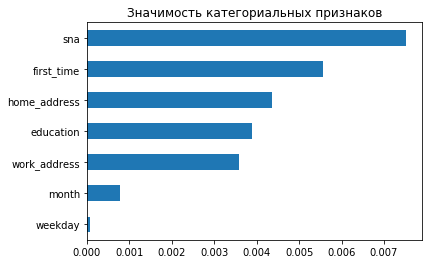

In [69]:
temp_df = df
imp_cat = pd.Series(mutual_info_classif(
    temp_df[cat_cols], temp_df['default'], discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Значимость категориальных признаков')

Сымый важный признак sna (уровень связи с другими клиентами )

In [70]:
df[cat_cols].nunique()

month           4
education       5
home_address    3
work_address    3
sna             4
first_time      4
weekday         7
dtype: int64

In [ ]:
#df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)
#df.info()

In [ ]:
#x_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
#x_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

#print(x_cat.shape)
#print(x_cat_test.shape)

графики показывают относительное распределение признаков по каждой группе клиентов: "хороших" и "плохих"

sex
car
car_type
good_work
foreign_passport
month
education
home_address
work_address
sna
first_time
weekday


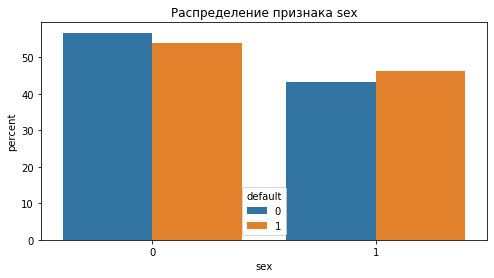

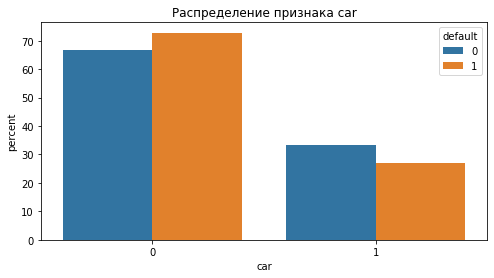

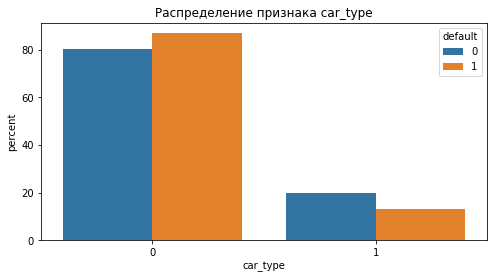

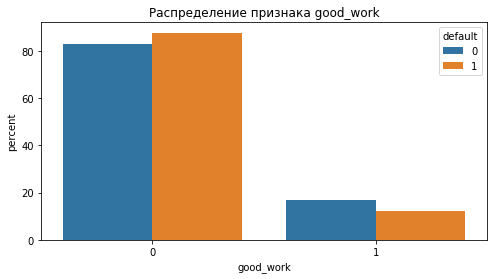

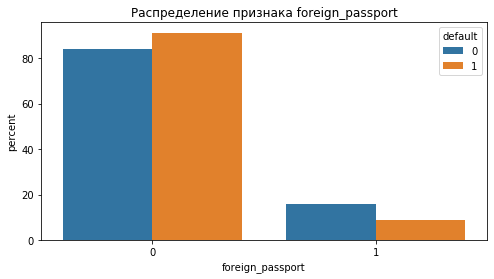

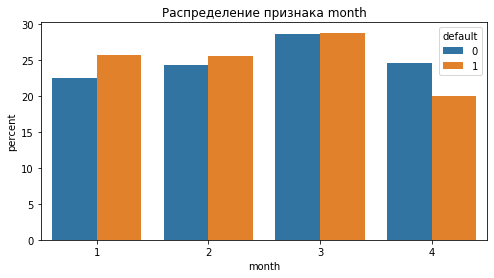

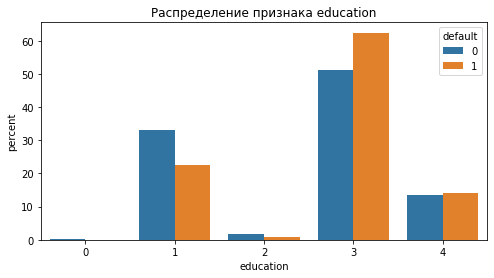

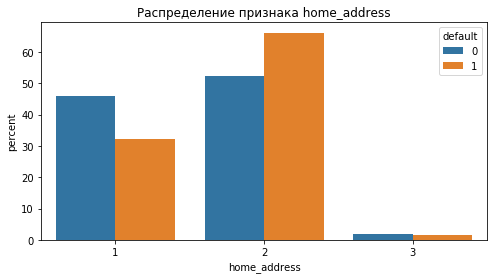

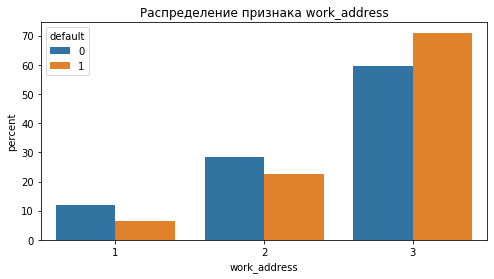

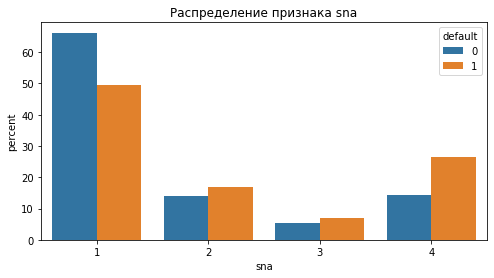

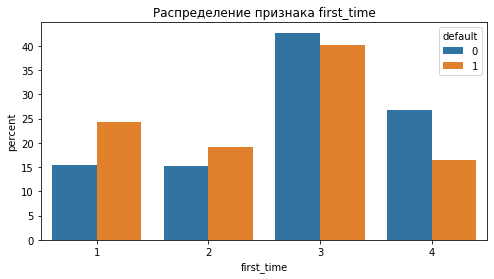

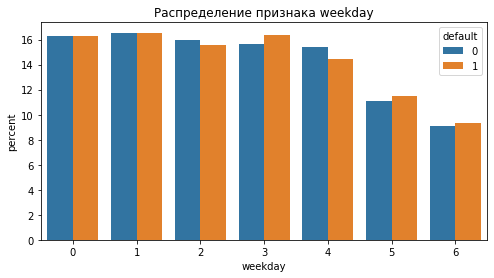

In [71]:
# теперь посмотрим распределение категориальных и бинарных признаков в зависимости от целевого признака

temp_df1 = df 
for col in bin_cols + cat_cols:
    plt.figure(figsize=(8, 4))
    prop_df = temp_df1[col].groupby(temp_df1["default"]).value_counts(normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    print(col)
    sns.barplot(x=col, hue="default", y="percent", data=prop_df) 
    plt.title(f"Распределение признака {col}")

## 3.Машинное обучение
### 3.1. Подготовка данных к машинному обучению
Стандартизируем числовые переменные

In [72]:
# Стандартизация числовых переменных
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols].values)

используем тот же скалер что мы обучили на трейне

In [73]:
X_num_test = scaler.transform(df_test[num_cols].values)

Преобразование категориальных значений в отдельные двоичные столбцы

In [74]:
oh_encoder = OneHotEncoder(sparse = False)
X_cat = oh_encoder.fit_transform(df[cat_cols].values)
X_cat

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [75]:
X_cat.shape

(73799, 30)

используем тот же энкодер что мы обучили на трейне

In [76]:
X_cat_test = oh_encoder.transform(df_test[cat_cols].values)
X_cat_test

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [77]:
X_cat_test.shape

(36349, 30)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [79]:
# Объединяем

X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

X_test = np.hstack([X_num_test, df_test[bin_cols].values, X_cat_test])

In [80]:
X.shape, Y.shape, X_test.shape

((73799, 42), (73799,), (36349, 42))

Подготовка признаков для модели завершена.

### 3.2. Обучение модели
Разделим данные для обучения следующим образом: Воспользуемся специальной функцие train_test_split для разбивки тестовых данных выделим 20% данных на валидацию (параметр test_size)

In [81]:
df = train
df_test = test
id_test = test['client_id']

In [82]:
X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

X_test = np.hstack([X_num_test, df_test[bin_cols].values, X_cat_test])

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [84]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter = 1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

Выполним регуляризацию. 
Поиск лучших гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидации

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

In [86]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

In [ ]:
param_grid = {'penalty': penalty, 
              'C':C,
               'solver': ['newton-cg', 'liblinear', 'lbfgs', 'sag', 'saga'],
               'class_weight':['none', 'balanced'],
               'multi_class': ['auto', 'ovr']}


gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X, Y)
model = gridsearch.best_estimator_

In [ ]:
# печатаем параметры
best_parameters = model.get_params()
best_parameters

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# 4. Submission

In [ ]:
df = train
df_test = test

In [ ]:
X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

X_test = np.hstack([X_num_test, df_test[bin_cols].values, X_cat_test])

In [ ]:
test.shape, train.shape, X.shape, X_train.shape, X_test.shape

In [ ]:
predict_submission = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(df_test.client_id)
submit['default']=predict_submission
submit.to_csv('submission.csv', index=False)
display(submit.head(10))

Ссылка на github с моим решением

 https://www.kaggle.com/c/sf-dst-scoring/submissions